Este cuaderno registra la taxonomia del archivo de las fotometrias generadas en las simulaciones

In [1]:
!pip install healpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 28.4 MB/s eta 0:00:00


In [2]:
# =============================================================================
# CONFIGURACIÓN E IMPORTACIONES ESPECÍFICAS PARA ARCHIVOS AGN
# =============================================================================

import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.neighbors import BallTree
import healpy as hp

print("=== INICIALIZACIÓN ANÁLISIS ARCHIVOS AGN ===")


=== INICIALIZACIÓN ANÁLISIS ARCHIVOS AGN ===


In [3]:
# =============================================================================
# CARGA DE ARCHIVOS AGN DESDE GOOGLE COLAB
# =============================================================================

from google.colab import files

print("=== SUBIENDO ARCHIVOS AGN ===")
uploaded = files.upload()

# Verificar archivos subidos
print("\n=== ARCHIVOS SUBIDOS ===")
for fn in uploaded.keys():
    print(f'Archivo: "{fn}" - Tamaño: {len(uploaded[fn])} bytes')

# Lista de archivos esperados
expected_files = [
    'AGN_20250918_1_PHOT.FITS',
    'AGN_20250918_1_HEAD.FITS',
    'AGN_20250918_1.DUMP'
]

print("\n=== VERIFICACIÓN DE ARCHIVOS ===")
for file in expected_files:
    if file in uploaded.keys():
        print(f"✅ {file} - CARGADO")
    else:
        print(f"❌ {file} - FALTANTE")

=== SUBIENDO ARCHIVOS AGN ===


Saving AGN_20250918_1.DUMP to AGN_20250918_1.DUMP
Saving AGN_20250918_1.LIST to AGN_20250918_1.LIST
Saving AGN_20250918_1.README to AGN_20250918_1.README
Saving AGN_20250918_1_HEAD.FITS to AGN_20250918_1_HEAD.FITS
Saving AGN_20250918_1_PHOT.FITS to AGN_20250918_1_PHOT.FITS

=== ARCHIVOS SUBIDOS ===
Archivo: "AGN_20250918_1.DUMP" - Tamaño: 1083464 bytes
Archivo: "AGN_20250918_1.LIST" - Tamaño: 24 bytes
Archivo: "AGN_20250918_1.README" - Tamaño: 4542 bytes
Archivo: "AGN_20250918_1_HEAD.FITS" - Tamaño: 1537920 bytes
Archivo: "AGN_20250918_1_PHOT.FITS" - Tamaño: 56560320 bytes

=== VERIFICACIÓN DE ARCHIVOS ===
✅ AGN_20250918_1_PHOT.FITS - CARGADO
✅ AGN_20250918_1_HEAD.FITS - CARGADO
✅ AGN_20250918_1.DUMP - CARGADO


In [4]:
# =============================================================================
# INSPECCIÓN DE ESTRUCTURA DE ARCHIVOS FITS
# =============================================================================

print("🔍 INSPECCIONANDO ESTRUCTURA DE ARCHIVOS FITS...")

# Inspeccionar PHOT.FITS
print("\n📁 ARCHIVO PHOT.FITS:")
with fits.open('AGN_20250918_1_PHOT.FITS') as hdul:
    hdul.info()
    phot_data = hdul[1].data
    print(f"   • Observaciones: {len(phot_data):,}")
    print(f"   • Columnas: {len(phot_data.names)}")
    print("   • Primeras 5 columnas:")
    for i, col in enumerate(phot_data.names[:5]):
        print(f"     {i}. {col}: {phot_data[col].dtype}")

# Inspeccionar HEAD.FITS
print("\n📁 ARCHIVO HEAD.FITS:")
with fits.open('AGN_20250918_1_HEAD.FITS') as hdul:
    hdul.info()
    head_data = hdul[1].data
    print(f"   • Objetos: {len(head_data):,}")
    print(f"   • Columnas: {len(head_data.names)}")
    print("   • Columnas clave:")
    key_cols = ['SNID', 'RA', 'DEC', 'REDSHIFT_FINAL', 'SNTYPE', 'PTROBS_MIN', 'PTROBS_MAX']
    for col in key_cols:
        if col in head_data.names:
            print(f"     • {col}: {head_data[col].dtype}")

🔍 INSPECCIONANDO ESTRUCTURA DE ARCHIVOS FITS...

📁 ARCHIVO PHOT.FITS:
Filename: AGN_20250918_1_PHOT.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (0,)      
  1  Photometry    1 BinTableHDU     69   642590R x 20C   [1D, 2A, 1I, 12A, 1J, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
   • Observaciones: 642,590
   • Columnas: 20
   • Primeras 5 columnas:
     0. MJD: >f8
     1. BAND: <U2
     2. CCDNUM: >i2
     3. FIELD: <U12
     4. PHOTFLAG: >i4

📁 ARCHIVO HEAD.FITS:
Filename: AGN_20250918_1_HEAD.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   (0,)      
  1  Header        1 BinTableHDU    489   2077R x 160C   [16A, 1I, 1D, 1D, 1E, 1I, 1I, 1J, 1J, 1J, 1J, 1E, 1E, 1E, 1E, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1I, 1I, 1K, 1I, 1E, 1E, 1E, 1E, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1K, 1E, 1K, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1

In [6]:
# =============================================================================
# CARGA DE DATOS A DATAFRAMES PANDAS
# =============================================================================

print("🔄 CARGANDO DATOS A DATAFRAMES...")

# Cargar datos fotométricos
phot_df = Table.read('AGN_20250918_1_PHOT.FITS', hdu=1).to_pandas()
print(f"✅ PHOT cargado: {len(phot_df):,} filas × {len(phot_df.columns)} columnas")

# Cargar metadatos
head_df = Table.read('AGN_20250918_1_HEAD.FITS', hdu=1).to_pandas()
print(f"✅ HEAD cargado: {len(head_df):,} filas × {len(head_df.columns)} columnas")

# Cargar DUMP (si existe)
try:
    dump_df = Table.read('AGN_20250918_1.DUMP', format='ascii').to_pandas()
    print(f"✅ DUMP cargado: {len(dump_df):,} filas × {len(dump_df.columns)} columnas")
except Exception as e:
    print(f"⚠️  DUMP no cargado: {e}")
    dump_df = pd.DataFrame()

print(f"\n📊 RESUMEN CARGA:")
print(f"   • Observaciones/objeto: {len(phot_df)/len(head_df):.1f}")
print(f"   • Memoria PHOT: {phot_df.memory_usage(deep=True).sum()/1e6:.1f} MB")
print(f"   • Memoria HEAD: {head_df.memory_usage(deep=True).sum()/1e6:.1f} MB")

🔄 CARGANDO DATOS A DATAFRAMES...
✅ PHOT cargado: 642,590 filas × 20 columnas
✅ HEAD cargado: 2,077 filas × 160 columnas
✅ DUMP cargado: 3,880 filas × 36 columnas

📊 RESUMEN CARGA:
   • Observaciones/objeto: 309.4
   • Memoria PHOT: 109.2 MB
   • Memoria HEAD: 1.7 MB


In [7]:
# =============================================================================
# MUESTRA DE DATOS CRUDOS
# =============================================================================

print("📋 MUESTRA DE DATOS CRUDOS (primeras 5 filas):")

print("\n📷 DATOS FOTOMÉTRICOS (PHOT):")
print(phot_df.head())

print("\n📄 METADATOS (HEAD):")
print(head_df[['SNID', 'RA', 'DEC', 'REDSHIFT_FINAL', 'SNTYPE']].head())

print(f"\n🎯 ESTADÍSTICAS INICIALES:")
print(f"   • Bandas en PHOT: {phot_df['BAND'].str.decode('utf-8').str.strip().unique()}")
print(f"   • Rango MJD: {phot_df['MJD'].min():.1f} - {phot_df['MJD'].max():.1f}")
print(f"   • Rango FLUXCAL: {phot_df['FLUXCAL'].min():.2e} - {phot_df['FLUXCAL'].max():.2e}")

📋 MUESTRA DE DATOS CRUDOS (primeras 5 filas):

📷 DATOS FOTOMÉTRICOS (PHOT):
          MJD   BAND  CCDNUM            FIELD  PHOTFLAG  PHOTPROB    FLUXCAL  \
0  60901.4118  b'z '      -9  b'VOID        '      4096      -9.0  86.814804   
1  60901.4218  b'Y '      -9  b'VOID        '         0      -9.0  56.565449   
2  60903.3063  b'r '      -9  b'VOID        '      6144      -9.0  61.337624   
3  60903.3309  b'i '      -9  b'VOID        '      4096      -9.0  63.932205   
4  60906.2561  b'i '      -9  b'VOID        '      4096      -9.0  55.186874   

   FLUXCALERR  PSF_SIG1  PSF_SIG2  PSF_RATIO    SKY_SIG  SKY_SIG_T  RDNOISE  \
0   13.172442      2.40       0.0        0.0  52.169998        0.0     0.25   
1   32.864513      2.39       0.0        0.0  48.230000        0.0     0.25   
2    5.226864      2.34       0.0        0.0  31.549999        0.0     0.25   
3    5.742804      1.88       0.0        0.0  39.009998        0.0     0.25   
4    4.784078      1.64       0.0        0.0  36

In [8]:
# =============================================================================
# TRANSFORMACIONES FÍSICAS - FLUJO A MAGNITUDES
# =============================================================================

print("🎯 APLICANDO TRANSFORMACIONES FÍSICAS...")

# Limpieza de bandas
phot_df['BAND'] = phot_df['BAND'].str.decode('utf-8').str.strip()
print(f"✅ Bandas limpiadas: {sorted(phot_df['BAND'].unique())}")

# Transformaciones físicas
def flux_to_mag_AB(flux):
    """Conversión flujo → magnitud AB con zeropoint 27.5"""
    if flux <= 0:
        return np.nan
    return 27.5 - 2.5 * np.log10(flux)

def flux_to_mag_err_AB(flux, flux_err):
    """Error en magnitud AB"""
    if flux <= 0:
        return np.nan
    return (2.5 / np.log(10)) * (flux_err / flux)

# Aplicar transformaciones
phot_df['FLUX_uJy'] = phot_df['FLUXCAL'] * 10**(-1.44)
phot_df['FLUX_uJy_ERR'] = phot_df['FLUXCALERR'] * 10**(-1.44)
phot_df['MAG_AB'] = phot_df.apply(lambda x: flux_to_mag_AB(x['FLUXCAL']), axis=1)
phot_df['MAG_AB_ERR'] = phot_df.apply(lambda x: flux_to_mag_err_AB(x['FLUXCAL'], x['FLUXCALERR']), axis=1)

# Preparar coordenadas para análisis espacial
head_df['rad_ra'] = np.radians(head_df['RA'])
head_df['rad_dec'] = np.radians(head_df['DEC'])

print("✅ TRANSFORMACIONES COMPLETADAS:")
print(f"   • Observaciones con flujo positivo: {(phot_df['FLUXCAL'] > 0).sum():,}")
print(f"   • Rango magnitudes AB: {phot_df['MAG_AB'].min():.2f} - {phot_df['MAG_AB'].max():.2f}")
print(f"   • Rango flujo μJy: {phot_df['FLUX_uJy'].min():.2f} - {phot_df['FLUX_uJy'].max():.2f}")

🎯 APLICANDO TRANSFORMACIONES FÍSICAS...
✅ Bandas limpiadas: ['-', 'Y', 'g', 'i', 'r', 'u', 'z']
✅ TRANSFORMACIONES COMPLETADAS:
   • Observaciones con flujo positivo: 332,878
   • Rango magnitudes AB: 17.99 - 38.19
   • Rango flujo μJy: -93.73 - 230.69


In [10]:
display(phot_df.head())

,MJD,BAND,CCDNUM,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,PSF_SIG2,...,ZEROPT,ZEROPT_ERR,GAIN,XPIX,YPIX,SIM_MAGOBS,FLUX_uJy,FLUX_uJy_ERR,MAG_AB,MAG_AB_ERR
0,60901.4118,z,-9,b'VOID ',4096,-9.0,86.814804,13.172442,2.40,0.0,...,31.330000,0.005,1.0,-9.0,-9.0,22.292189,3.152055,0.478262,22.653516,0.164739
1,60901.4218,Y,-9,b'VOID ',0,-9.0,56.565449,32.864513,2.39,0.0,...,30.240000,0.005,1.0,-9.0,-9.0,22.458427,2.053767,1.193238,23.118622,0.630812
2,60903.3063,r,-9,b'VOID ',6144,-9.0,61.337624,5.226864,2.34,0.0,...,31.780001,0.005,1.0,-9.0,-9.0,22.713169,2.227034,0.189776,23.030683,0.092521
3,60903.3309,i,-9,b'VOID ',4096,-9.0,63.932205,5.742804,1.88,0.0,...,31.670000,0.005,1.0,-9.0,-9.0,22.693703,2.321238,0.208509,22.985701,0.097528
4,60906.2561,i,-9,b'VOID ',4096,-9.0,55.186874,4.784078,1.64,0.0,...,31.650000,0.005,1.0,-9.0,-9.0,22.786180,2.003714,0.173699,23.145411,0.094121


In [11]:
display(head_df.head())


,SNID,FAKE,RA,DEC,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,...,SIM_EXPOSURE_Y,SIM_TEMPLATEMAG_u,SIM_TEMPLATEMAG_g,SIM_TEMPLATEMAG_r,SIM_TEMPLATEMAG_i,SIM_TEMPLATEMAG_z,SIM_TEMPLATEMAG_Y,SIM_SUBSAMPLE_INDEX,rad_ra,rad_dec
0,b'2 ',2,20.302326,-49.896984,0.2,-9,-9,0,277,1,...,1.0,24.695511,24.671490,24.434269,24.258335,23.726646,23.803957,-9,0.354342,-0.870867
1,b'5 ',2,65.390625,-24.460292,0.2,-9,-9,0,352,279,...,1.0,28.077406,27.719353,27.504255,27.116535,26.902767,26.314753,-9,1.141282,-0.426913
2,b'7 ',2,219.255319,-64.011237,0.2,-9,-9,0,270,632,...,1.0,22.309166,21.498079,20.775850,20.433058,19.898575,19.665665,-9,3.826727,-1.117207
3,b'9 ',2,233.964844,-26.944358,0.2,-9,-9,0,302,903,...,1.0,25.002676,24.363735,23.978939,23.549522,23.280903,23.006483,-9,4.083457,-0.470268
4,b'10 ',2,162.949219,5.679190,0.2,-9,-9,0,248,1206,...,1.0,23.153952,23.010326,22.751415,22.726074,22.758089,22.571112,-9,2.844000,0.099121


In [12]:
# =============================================================================
# VINCULACIÓN OBSERVACIONES ↔ METADATOS
# =============================================================================

print("🔗 VINCULANDO OBSERVACIONES CON METADATOS...")

linked_data = []
total_linked = 0

for idx, head_row in head_df.iterrows():
    obs_min = head_row['PTROBS_MIN']
    obs_max = head_row['PTROBS_MAX']

    obj_phot = phot_df.iloc[obs_min:obs_max + 1].copy()
    obj_phot['SNID'] = head_row['SNID']
    obj_phot['RA'] = head_row['RA']
    obj_phot['DEC'] = head_row['DEC']
    obj_phot['REDSHIFT_FINAL'] = head_row['REDSHIFT_FINAL']
    obj_phot['SNTYPE'] = head_row['SNTYPE']

    linked_data.append(obj_phot)
    total_linked += len(obj_phot)

linked_df = pd.concat(linked_data, ignore_index=True)

print("✅ VINCULACIÓN COMPLETADA:")
print(f"   • Objetos procesados: {len(head_df):,}")
print(f"   • Observaciones vinculadas: {len(linked_df):,}")
print(f"   • Verificación: {total_linked == len(linked_df)}")

# Mostrar muestra de datos vinculados
print("\n📋 MUESTRA DATOS VINCULADOS:")
print(linked_df[['SNID', 'MJD', 'BAND', 'MAG_AB', 'REDSHIFT_FINAL']].head())

🔗 VINCULANDO OBSERVACIONES CON METADATOS...
✅ VINCULACIÓN COMPLETADA:
   • Objetos procesados: 2,077
   • Observaciones vinculadas: 640,513
   • Verificación: True

📋 MUESTRA DATOS VINCULADOS:
                  SNID         MJD BAND     MAG_AB  REDSHIFT_FINAL
0  b'2               '  60901.4218    Y  23.118622        0.323512
1  b'2               '  60903.3063    r  23.030683        0.323512
2  b'2               '  60903.3309    i  22.985701        0.323512
3  b'2               '  60906.2561    i  23.145411        0.323512
4  b'2               '  60906.2806    z  22.476766        0.323512


In [13]:
# =============================================================================
# ANÁLISIS ESTADÍSTICO BÁSICO
# =============================================================================

print("📊 ANÁLISIS ESTADÍSTICO BÁSICO:")

# Estadísticas generales
print(f"\n🎯 ESTADÍSTICAS GENERALES:")
print(f"   • Objetos AGN: {len(head_df):,}")
print(f"   • Observaciones totales: {len(linked_df):,}")
print(f"   • Observaciones/objeto: {len(linked_df)/len(head_df):.1f}")

# Estadísticas por banda
print(f"\n🎯 ESTADÍSTICAS POR BANDA:")
band_stats = linked_df.groupby('BAND').agg({
    'MAG_AB': ['count', 'mean', 'std', 'min', 'max'],
    'FLUX_uJy': ['mean', 'std']
}).round(3)
print(band_stats)

# Estadísticas de redshift
print(f"\n🎯 ESTADÍSTICAS REDSHIFT:")
redshift_stats = head_df['REDSHIFT_FINAL'].describe()
print(redshift_stats)

# Distribución de tipos
print(f"\n🎯 DISTRIBUCIÓN DE TIPOS SN:")
type_counts = head_df['SNTYPE'].value_counts().sort_index()
for sn_type, count in type_counts.items():
    print(f"   • SNTYPE {sn_type}: {count} objetos")

print(f"\n📈 RESUMEN CALIDAD:")
valid_obs = (linked_df['FLUXCAL'] > 0).sum()
print(f"   • Observaciones válidas: {valid_obs:,}/{len(linked_df):,} ({valid_obs/len(linked_df)*100:.1f}%)")
print(f"   • Bandas con datos: {len(linked_df['BAND'].unique())}")

📊 ANÁLISIS ESTADÍSTICO BÁSICO:

🎯 ESTADÍSTICAS GENERALES:
   • Objetos AGN: 2,077
   • Observaciones totales: 640,513
   • Observaciones/objeto: 308.4

🎯 ESTADÍSTICAS POR BANDA:
     MAG_AB                                FLUX_uJy       
      count    mean    std     min     max     mean    std
BAND                                                      
-         0     NaN    NaN     NaN     NaN  -28.211  0.000
Y     68089  23.925  1.378  17.992  35.564    0.111  4.162
g     29603  24.756  1.524  18.712  35.184    0.119  2.980
i     76343  24.542  1.492  18.567  38.194    0.123  3.347
r     75538  24.661  1.510  18.755  35.907    0.131  3.066
u     20498  24.635  1.493  18.856  35.261    0.131  2.730
z     61746  24.308  1.461  18.443  36.155    0.119  3.813

🎯 ESTADÍSTICAS REDSHIFT:
count    2077.000000
mean        0.731081
std         0.562888
min         0.078781
25%         0.323512
50%         0.556236
75%         0.878099
max         3.404258
Name: REDSHIFT_FINAL, dtype: float64



🗺️ ANALIZANDO DISTRIBUCIÓN ESPACIAL...


<Figure size 1200x600 with 0 Axes>

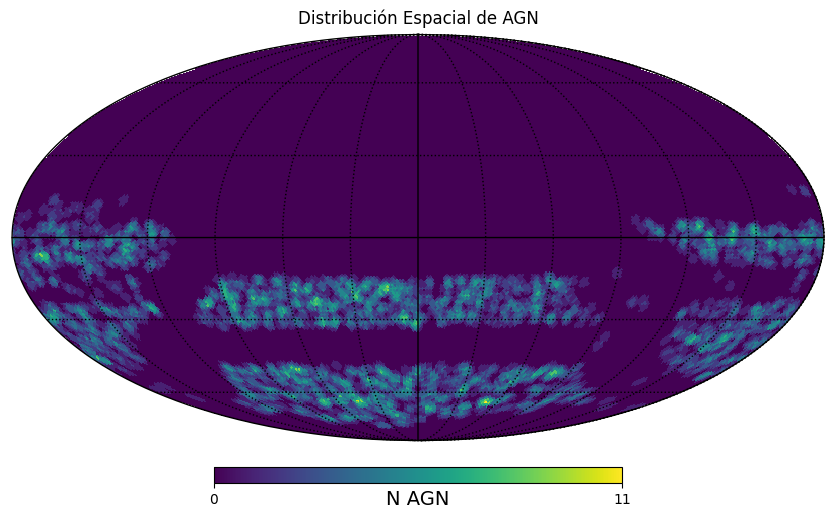

✅ ANÁLISIS ESPACIAL COMPLETADO:
   • Píxeles con AGN: 12,483
   • Área cubierta: 10476.9 grados²
   • Densidad: 0.20 AGN/grado²
   • AGN más aislado: 11 por píxel


In [14]:
# =============================================================================
# ANÁLISIS DE DISTRIBUCIÓN ESPACIAL
# =============================================================================

print("🗺️ ANALIZANDO DISTRIBUCIÓN ESPACIAL...")

# Crear árbol espacial
coords = head_df[['rad_dec', 'rad_ra']].values
tree = BallTree(coords, metric='haversine')

# Configurar HEALPix
nside = 64
npix = hp.nside2npix(nside)

# Contar objetos por píxel
ipix = np.arange(npix)
hp_ra, hp_dec = np.radians(hp.pix2ang(nside, ipix, lonlat=True))

n_objects_per_pixel = tree.query_radius(
    np.column_stack([hp_dec, hp_ra]),
    r=np.radians(2.0),
    count_only=True
)

# Crear y visualizar mapa
sky_map = np.zeros(npix)
sky_map[ipix] = n_objects_per_pixel

plt.figure(figsize=(12, 6))
hp.mollview(sky_map, title="Distribución Espacial de AGN", unit="N AGN", min=0)
hp.graticule()
plt.show()

# Estadísticas espaciales
populated_pixels = np.sum(n_objects_per_pixel > 0)
total_area_deg2 = hp.nside2pixarea(nside, degrees=True) * populated_pixels

print("✅ ANÁLISIS ESPACIAL COMPLETADO:")
print(f"   • Píxeles con AGN: {populated_pixels:,}")
print(f"   • Área cubierta: {total_area_deg2:.1f} grados²")
print(f"   • Densidad: {len(head_df)/total_area_deg2:.2f} AGN/grado²")
print(f"   • AGN más aislado: {np.max(n_objects_per_pixel)} por píxel")

📊 GENERANDO HISTOGRAMA DE REDSHIFT_FINAL...


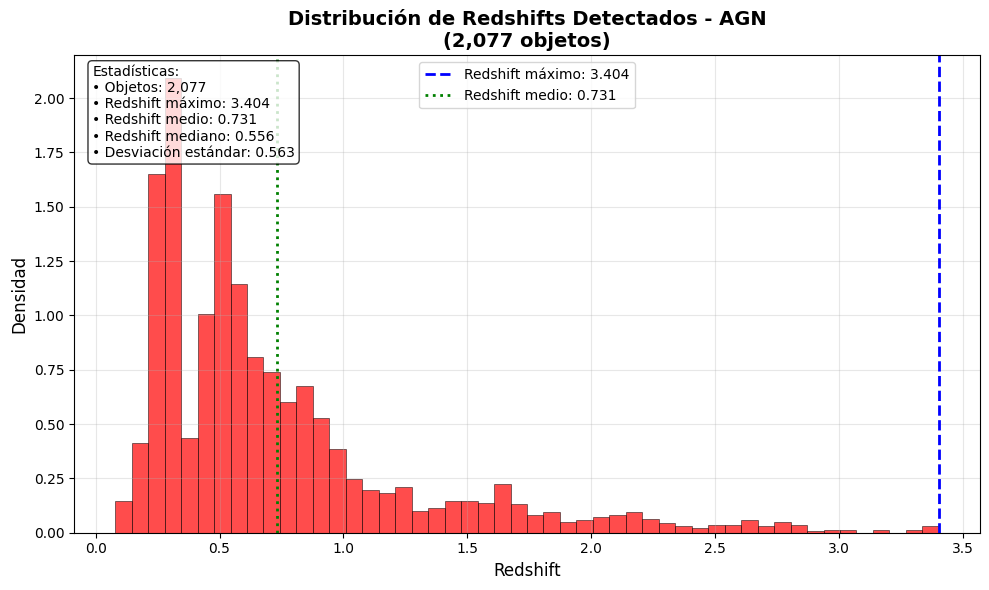

✅ Histograma de redshift_final generado


In [29]:
# =============================================================================
# HISTOGRAMA DE REDSHIFT_FINAL PARA AGN
# =============================================================================

print("📊 GENERANDO HISTOGRAMA DE REDSHIFT_FINAL...")

if det_z_col in head_df.columns:
    plt.figure(figsize=(10, 6))

    # Histograma de redshifts detectados
    n, bins, patches = plt.hist(
        head_df[det_z_col],
        bins=50,
        density=True,
        alpha=0.7,
        color='red',
        edgecolor='black',
        linewidth=0.5
    )

    # Línea vertical con redshift máximo
    max_redshift = head_df[det_z_col].max()
    plt.axvline(max_redshift, color='blue', linestyle='--', linewidth=2,
                label=f'Redshift máximo: {max_redshift:.3f}')

    # Estadísticas
    mean_redshift = head_df[det_z_col].mean()
    median_redshift = head_df[det_z_col].median()
    plt.axvline(mean_redshift, color='green', linestyle=':', linewidth=2,
                label=f'Redshift medio: {mean_redshift:.3f}')

    plt.xlabel('Redshift', fontsize=12)
    plt.ylabel('Densidad', fontsize=12)
    plt.title(f'Distribución de Redshifts Detectados - AGN\n({len(head_df):,} objetos)',
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Añadir texto con estadísticas
    stats_text = f'''Estadísticas:
• Objetos: {len(head_df):,}
• Redshift máximo: {max_redshift:.3f}
• Redshift medio: {mean_redshift:.3f}
• Redshift mediano: {median_redshift:.3f}
• Desviación estándar: {head_df[det_z_col].std():.3f}'''

    plt.annotate(stats_text, xy=(0.02, 0.98), xycoords='axes fraction',
                 verticalalignment='top', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

    print("✅ Histograma de redshift_final generado")
else:
    print(f"❌ Columna {det_z_col} no encontrada en HEAD")

📊 GENERANDO HISTOGRAMA COMPARATIVO ZCMB...


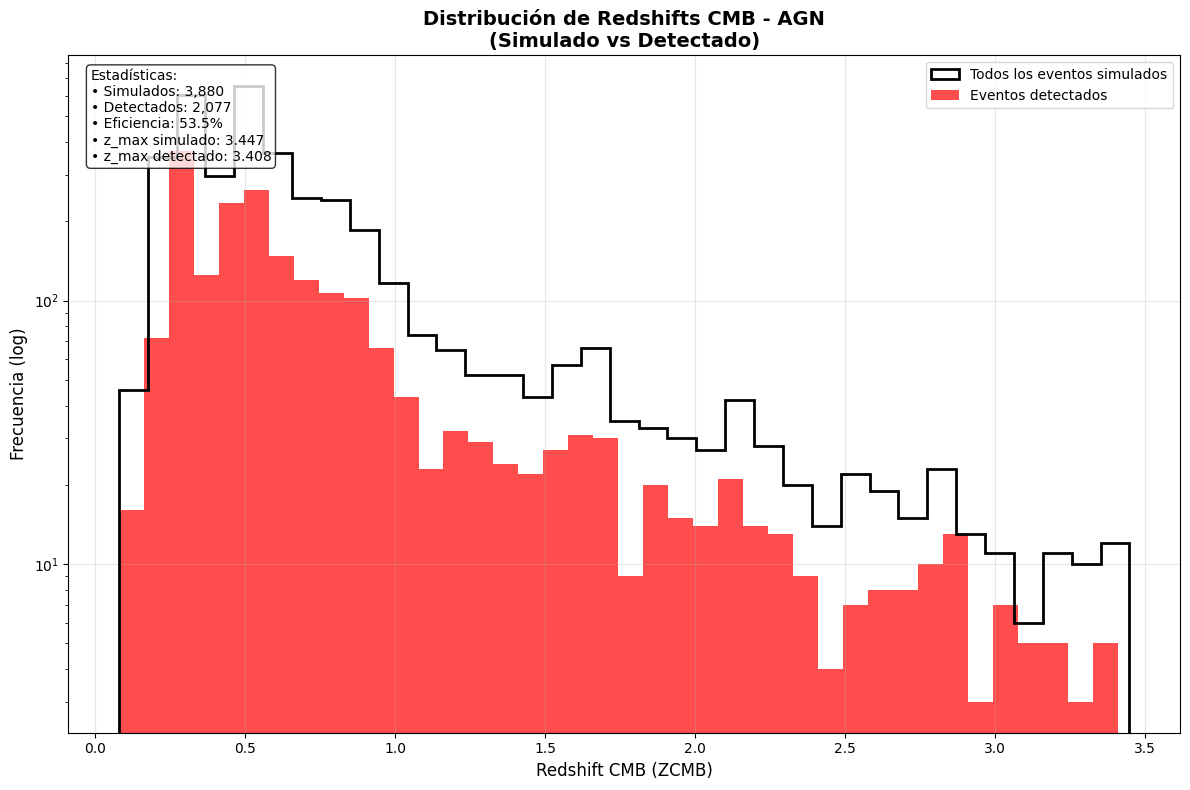

✅ Histograma comparativo ZCMB generado

📈 EFICIENCIA POR BIN DE REDSHIFT:
   • z = [0.00, 0.69): 53.0%
   • z = [0.69, 1.38): 53.8%
   • z = [1.38, 2.07): 56.9%
   • z = [2.07, 2.76): 51.5%
   • z = [2.76, 3.45): 57.5%


In [30]:
# =============================================================================
# HISTOGRAMA COMPARATIVO ZCMB - SIMULADO vs DETECTADO
# =============================================================================

print("📊 GENERANDO HISTOGRAMA COMPARATIVO ZCMB...")

# Buscar columnas ZCMB en DUMP
zcmb_cols = [col for col in dump_df.columns if 'ZCMB' in col.upper()]
sim_zcmb_col = zcmb_cols[0] if zcmb_cols else sim_z_col

if sim_zcmb_col and not dump_df.empty:
    # Crear máscara para eventos detectados
    detected_mask = dump_df.index.isin(head_df.index)

    plt.figure(figsize=(12, 8))

    # Histograma de todos los eventos simulados
    plt.hist(
        dump_df[sim_zcmb_col],
        bins=35,
        color='black',
        histtype='step',
        linewidth=2,
        label='Todos los eventos simulados',
        log=True
    )

    # Histograma de eventos detectados
    if detected_mask.any():
        plt.hist(
            dump_df[detected_mask][sim_zcmb_col],
            bins=40,
        color='red',
        alpha=0.7,
        label='Eventos detectados',
        log=True
    )

    plt.xlabel(f'Redshift CMB ({sim_zcmb_col})', fontsize=12)
    plt.ylabel('Frecuencia (log)', fontsize=12)
    plt.title('Distribución de Redshifts CMB - AGN\n(Simulado vs Detectado)',
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Añadir estadísticas
    if detected_mask.any():
        stats_text = f'''Estadísticas:
• Simulados: {len(dump_df):,}
• Detectados: {detected_mask.sum():,}
• Eficiencia: {detected_mask.sum()/len(dump_df)*100:.1f}%
• z_max simulado: {dump_df[sim_zcmb_col].max():.3f}
• z_max detectado: {dump_df[detected_mask][sim_zcmb_col].max():.3f}'''

        plt.annotate(stats_text, xy=(0.02, 0.98), xycoords='axes fraction',
                     verticalalignment='top', fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

    print("✅ Histograma comparativo ZCMB generado")

    # Calcular eficiencia por bin de redshift
    if detected_mask.any():
        print(f"\n📈 EFICIENCIA POR BIN DE REDSHIFT:")
        z_bins = np.linspace(0, dump_df[sim_zcmb_col].max(), 6)
        for i in range(len(z_bins)-1):
            bin_mask = (dump_df[sim_zcmb_col] >= z_bins[i]) & (dump_df[sim_zcmb_col] < z_bins[i+1])
            bin_detected = detected_mask & bin_mask
            efficiency = bin_detected.sum() / bin_mask.sum() * 100 if bin_mask.sum() > 0 else 0
            print(f"   • z = [{z_bins[i]:.2f}, {z_bins[i+1]:.2f}): {efficiency:.1f}%")

else:
    print("❌ No se puede generar histograma - faltan datos de ZCMB")

In [32]:
# =============================================================================
# RESUMEN COMPLETO DE ANÁLISIS DE REDSHIFTS
# =============================================================================

print("="*60)
print("📊 RESUMEN COMPLETO - ANÁLISIS DE REDSHIFTS AGN")
print("="*60)

if not dump_df.empty and sim_zcmb_col and det_z_col:
    # Estadísticas de detección
    detected_mask = dump_df.index.isin(head_df.index)

    print(f"🎯 ESTADÍSTICAS DE DETECCIÓN:")
    print(f"   • Eventos simulados totales: {len(dump_df):,}")
    print(f"   • Eventos detectados: {detected_mask.sum():,}")
    print(f"   • Eficiencia global: {detected_mask.sum()/len(dump_df)*100:.2f}%")

    print(f"\n📈 ESTADÍSTICAS DE REDSHIFT:")
    print(f"   • Redshift máximo simulado: {dump_df[sim_zcmb_col].max():.3f}")
    print(f"   • Redshift máximo detectado: {head_df[det_z_col].max():.3f}")
    print(f"   • Redshift medio detectado: {head_df[det_z_col].mean():.3f}")
    print(f"   • Redshift mediano detectado: {head_df[det_z_col].median():.3f}")

    # Eficiencia por rango de redshift
    print(f"\n📊 EFICIENCIA POR RANGO DE REDSHIFT:")
    z_ranges = [(0, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, dump_df[sim_zcmb_col].max())]

    for z_min, z_max in z_ranges:
        if z_min < dump_df[sim_zcmb_col].max():
            range_mask = (dump_df[sim_zcmb_col] >= z_min) & (dump_df[sim_zcmb_col] < z_max)
            if range_mask.any():
                range_detected = detected_mask & range_mask
                efficiency = range_detected.sum() / range_mask.sum() * 100
                n_sim = range_mask.sum()
                n_det = range_detected.sum()
                print(f"   • z [{z_min:.1f}, {z_max:.1f}): {n_det}/{n_sim} = {efficiency:.1f}%")

    print(f"\n✅ ANÁLISIS DE REDSHIFTS COMPLETADO")
else:
    print("❌ No se pudo completar el análisis - faltan datos esenciales")

📊 RESUMEN COMPLETO - ANÁLISIS DE REDSHIFTS AGN
🎯 ESTADÍSTICAS DE DETECCIÓN:
   • Eventos simulados totales: 3,880
   • Eventos detectados: 2,077
   • Eficiencia global: 53.53%

📈 ESTADÍSTICAS DE REDSHIFT:
   • Redshift máximo simulado: 3.447
   • Redshift máximo detectado: 3.404
   • Redshift medio detectado: 0.731
   • Redshift mediano detectado: 0.556

📊 EFICIENCIA POR RANGO DE REDSHIFT:
   • z [0.0, 0.5): 841/1576 = 53.4%
   • z [0.5, 1.0): 786/1478 = 53.2%
   • z [1.0, 1.5): 171/325 = 52.6%
   • z [1.5, 2.0): 132/228 = 57.9%
   • z [2.0, 3.4): 147/272 = 54.0%

✅ ANÁLISIS DE REDSHIFTS COMPLETADO


📊 ANALIZANDO Y GRAFICANDO NÚMERO DE DETECCIONES POR AGN...
Procesando 2077 objetos AGN...
Generando histogramas...


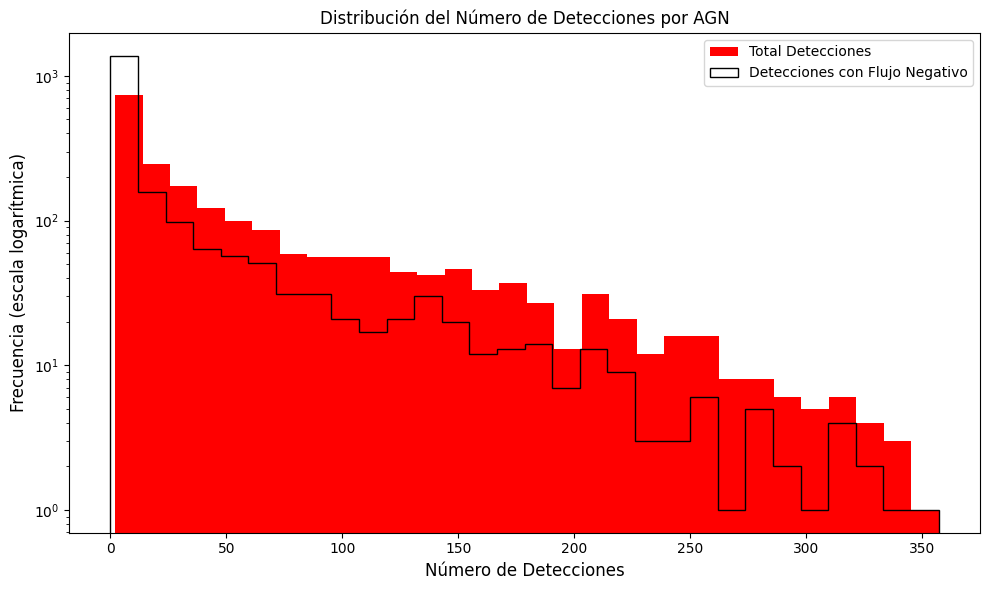

✅ Análisis y gráfico de número de detecciones completado.

=== ESTADÍSTICAS DE DETECCIONES ===
Número promedio de detecciones por AGN: 59.93
Número promedio de detecciones con flujo negativo por AGN: 27.19
AGN con más detecciones: 357
AGN con más detecciones de flujo negativo: 357


In [33]:
# =============================================================================
# ANÁLISIS Y VISUALIZACIÓN DEL NÚMERO DE DETECCIONES POR AGN
# =============================================================================

print("📊 ANALIZANDO Y GRAFICANDO NÚMERO DE DETECCIONES POR AGN...")

# Fundamento Astronómico:
# El número de detecciones para un objeto astronómico, especialmente un transiente como un AGN,
# es crucial para caracterizar su comportamiento a lo largo del tiempo. Un mayor número de
# detecciones a menudo implica una curva de luz mejor muestreada, lo que permite una mejor
# determinación de propiedades como la magnitud máxima, la duración del evento y los parámetros
# de variabilidad.
#
# Las detecciones con flujo negativo (FLUX_uJy < 0) son un indicador importante de ruido
# o problemas en el fondo del cielo (sky subtraction). Analizar su frecuencia y distribución
# nos ayuda a evaluar la calidad de la fotometría y a identificar posibles limitaciones
# en la capacidad de detección, especialmente para objetos débiles. Una alta tasa de
# detecciones con flujo negativo puede sugerir que el límite de detección es demasiado somero
# o que hay problemas sistemáticos en el procesamiento de las imágenes.

if not head_df.empty and not phot_df.empty:
    # Listas para almacenar el número de detecciones
    n_detecciones = []
    n_neg_flux = []

    print(f"Procesando {len(head_df)} objetos AGN...")

    # Iterar sobre cada objeto AGN en el DataFrame de metadatos (head_df)
    for index, obj_meta in head_df.iterrows():
        # Extraer el rango de observaciones para este objeto usando PTROBS_MIN y PTROBS_MAX
        # Restamos 1 a PTROBS_MIN porque los índices de pandas son base 0,
        # mientras que PTROBS_MIN/MAX en SNANA suelen ser base 1.
        # Aseguramos que los valores de índice son válidos para el DataFrame phot_df
        first_obs_idx = obj_meta['PTROBS_MIN'] - 1
        last_obs_idx = obj_meta['PTROBS_MAX']

        # Seleccionar las observaciones correspondientes a este objeto
        # Usamos iloc para seleccionar por índice de posición
        obj_obs = phot_df.iloc[first_obs_idx : last_obs_idx + 1]

        # Filtrar observaciones consideradas "detecciones"
        # Según la documentación de SNANA, PHOTFLAG = 4096 o 6144 indican una detección.
        # PHOTFLAG = 4096: Detection
        # PHOTFLAG = 6144: Detection (with some flag, e.g., saturated pixel)
        # Consideramos ambas como "detecciones" en este contexto.
        detections = obj_obs[(obj_obs['PHOTFLAG'] == 4096) | (obj_obs['PHOTFLAG'] == 6144)].copy()

        # Contar el número total de detecciones para este objeto
        n_detecciones.append(len(detections))

        # Contar el número de detecciones con flujo negativo
        neg_detections = detections[detections['FLUX_uJy'] < 0]
        n_neg_flux.append(len(neg_detections))

    # Convertir las listas a Series de pandas para facilitar el ploteo
    detections_series = pd.Series(n_detecciones, index=head_df.index)
    neg_flux_series = pd.Series(n_neg_flux, index=head_df.index)

    print("Generando histogramas...")

    # Crear figura y ejes para los histogramas
    fig, ax = plt.subplots(figsize=(10, 6))

    # Histograma del número total de detecciones
    detections_series.hist(bins=30, density=False, ax=ax, grid=False, color='r', log=True, label='Total Detecciones')

    # Histograma del número de detecciones con flujo negativo (como un paso)
    # Usamos bins similares para una comparación visual más fácil
    neg_flux_series.hist(bins=30, ax=ax, grid=False, color='k', log=True, histtype='step', label='Detecciones con Flujo Negativo')


    # Configurar título y etiquetas del gráfico
    ax.set_title('Distribución del Número de Detecciones por AGN', size='large', y=1.0)
    ax.set_xlabel('Número de Detecciones', size='large')
    ax.set_ylabel('Frecuencia (escala logarítmica)', size='large')
    ax.legend() # Mostrar la leyenda para identificar los histogramas

    # Ajustar diseño y mostrar el gráfico
    plt.tight_layout()
    plt.show()

    print("✅ Análisis y gráfico de número de detecciones completado.")

    # Opcional: Imprimir algunas estadísticas resumen
    print("\n=== ESTADÍSTICAS DE DETECCIONES ===")
    print(f"Número promedio de detecciones por AGN: {detections_series.mean():.2f}")
    print(f"Número promedio de detecciones con flujo negativo por AGN: {neg_flux_series.mean():.2f}")
    print(f"AGN con más detecciones: {detections_series.max():.0f}")
    print(f"AGN con más detecciones de flujo negativo: {neg_flux_series.max():.0f}")


else:
    print("❌ No se pueden realizar análisis - head_df o phot_df están vacíos.")

📊 GENERANDO HISTOGRAMA DE MAGNITUDES CONTRASTADO...


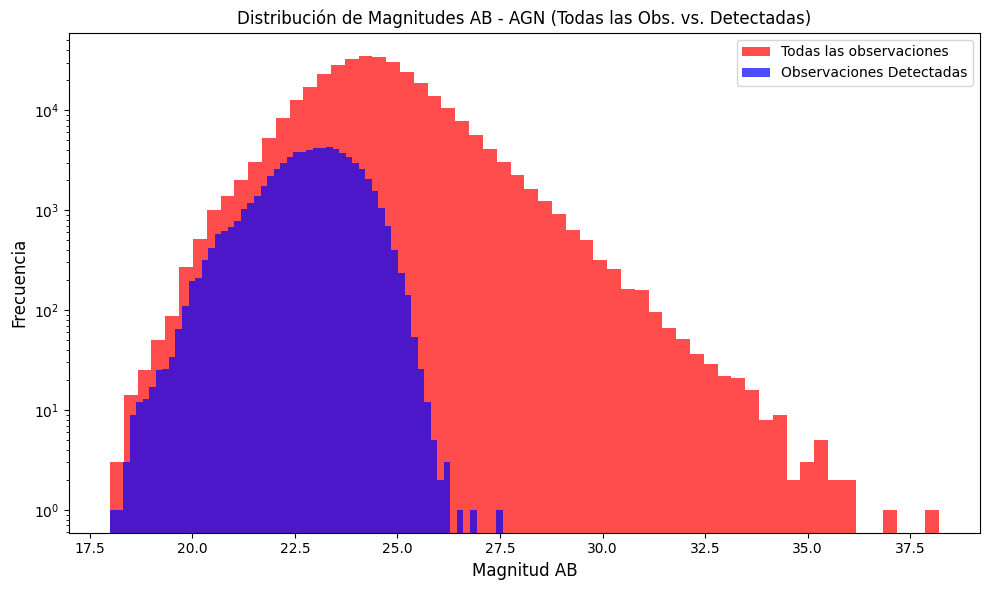

✅ Histograma de magnitudes contrastado generado.


In [35]:
# =============================================================================
# ANÁLISIS Y VISUALIZACIÓN: HISTOGRAMA DE MAGNITUDES CONTRASTADO
# =============================================================================

print("📊 GENERANDO HISTOGRAMA DE MAGNITUDES CONTRASTADO...")

# Fundamento Astronómico:
# Los histogramas de magnitud son herramientas esenciales en astronomía para visualizar
# la distribución de brillo de una población de objetos. Contrastar la distribución de
# magnitudes de todas las observaciones con la de las observaciones *detectadas* es
# fundamental para entender los sesgos de selección de un relevamiento.
#
# La distribución de todas las observaciones (simuladas o reales) nos da una idea de la
# población intrínseca y la contribución del ruido. La distribución de las observaciones
# *detectadas*, por otro lado, muestra qué parte de esa población es efectivamente visible
# con los criterios de detección aplicados. La diferencia entre ambas distribuciones
# revela la "función de selección" del relevamiento, mostrando a qué magnitudes se vuelve
# incompleto o incapaz de detectar objetos.
#
# Se espera ver que las detecciones se concentran en magnitudes más brillantes (valores de MAG_AB menores)
# en comparación con todas las observaciones, que pueden extenderse a magnitudes mucho más débiles
# (valores de MAG_AB mayores), a menudo dominadas por el ruido. La escala logarítmica en la
# frecuencia para las detecciones es útil para visualizar la cola de objetos más débiles detectados.


if not phot_df.empty and 'MAG_AB' in phot_df.columns and 'PHOTFLAG' in phot_df.columns:
    # Crear figura y ejes para el histograma
    fig, ax = plt.subplots(figsize=(10, 6))

    # Histograma de todas las observaciones (con magnitud válida)
    # Filtramos los NaN en MAG_AB para el histograma
    all_magnitudes = phot_df['MAG_AB'].dropna()
    if not all_magnitudes.empty:
        all_magnitudes.hist(bins=60, density=False, ax=ax, grid=False, color='r', alpha=0.7, label='Todas las observaciones')

    # Filtrar observaciones consideradas "detecciones"
    # Según la documentación de SNANA, PHOTFLAG = 4096 o 6144 indican una detección.
    detections_df = phot_df[(phot_df['PHOTFLAG'] == 4096) | (phot_df['PHOTFLAG'] == 6144)].copy()

    # Histograma de magnitudes de las detecciones (con magnitud válida)
    detected_magnitudes = detections_df['MAG_AB'].dropna()
    if not detected_magnitudes.empty:
        # Usamos los mismos bins para consistencia visual
        detected_magnitudes.hist(bins=60, density=False, ax=ax, grid=False, color='b', alpha=0.7, log=True, label='Observaciones Detectadas')


    # Configurar título y etiquetas
    ax.set_title('Distribución de Magnitudes AB - AGN (Todas las Obs. vs. Detectadas)', size='large')
    ax.set_xlabel('Magnitud AB', size='large')
    ax.set_ylabel('Frecuencia', size='large') # Density=False means raw counts

    ax.legend()
    ax.grid(False) # Disable grid as in example
    # ax.invert_xaxis() # Magnitudes: más brillante = menor valor, so invert x-axis ***preguntar

    plt.tight_layout()
    plt.show()

    print("✅ Histograma de magnitudes contrastado generado.")

else:
    print("❌ No se pueden generar gráficos - phot_df vacío o faltan columnas esenciales ('MAG_AB', 'PHOTFLAG').")

📈 GENERANDO CURVAS DE LUZ MEJORADAS...
🔍 Objetos seleccionados: 10 aleatorios


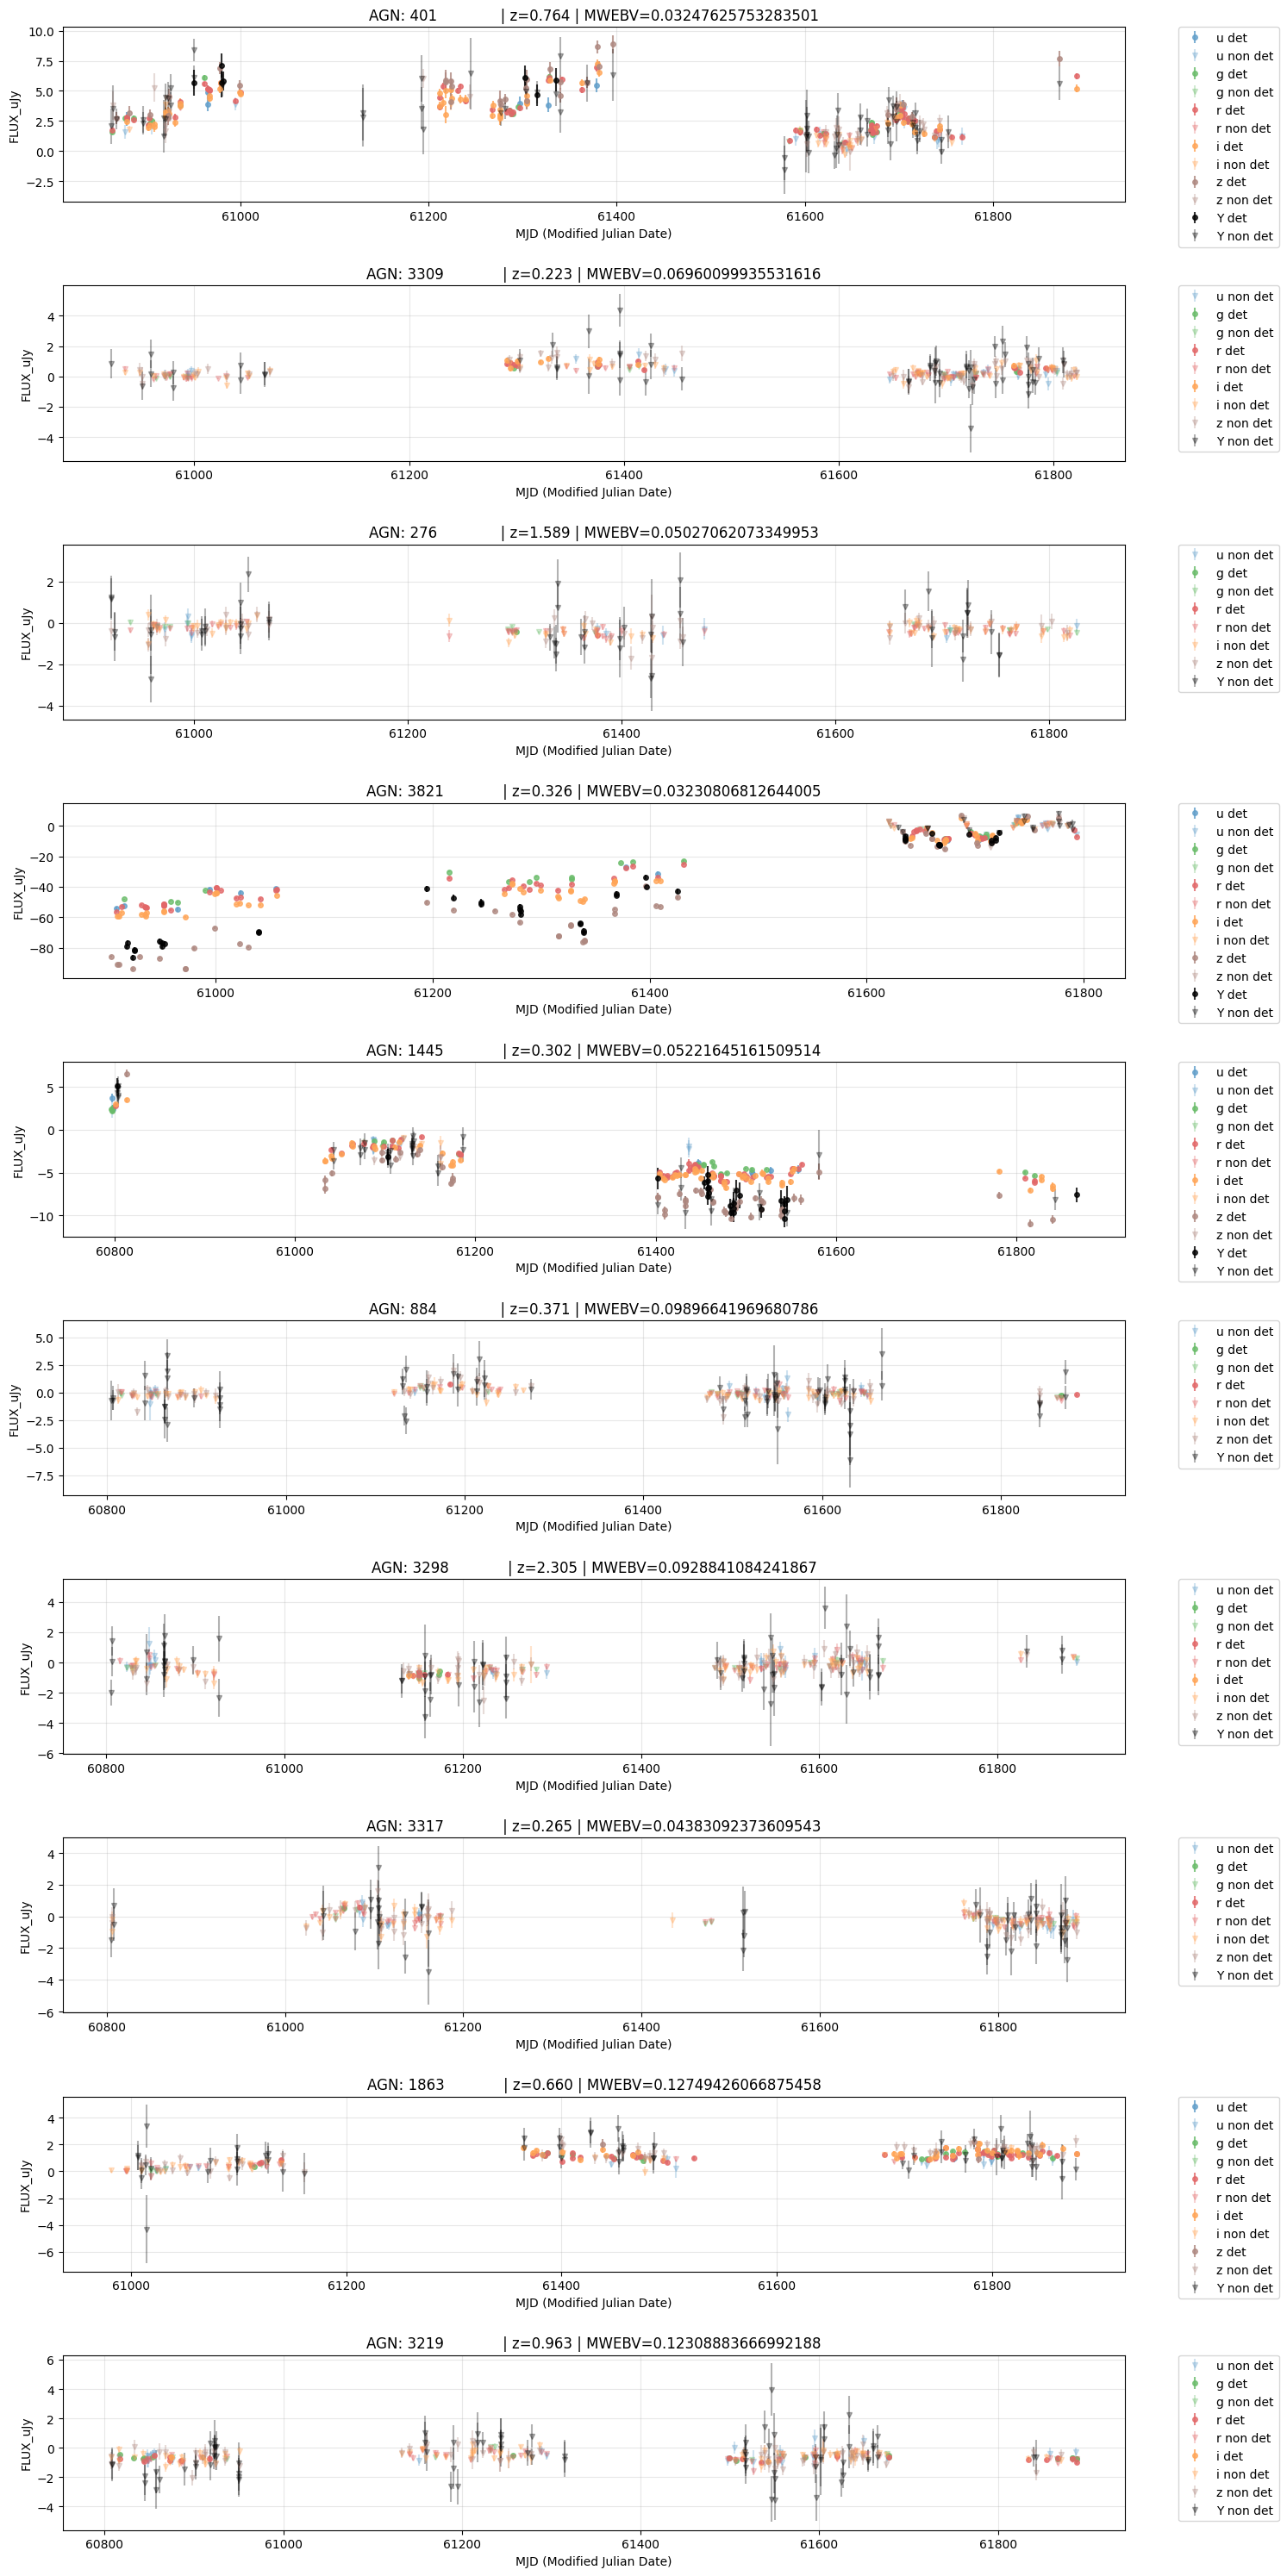

✅ CURVAS DE LUZ MEJORADAS GENERADAS


In [43]:
# =============================================================================
# VISUALIZACIÓN DE CURVAS DE LUZ MEJORADA
# =============================================================================

print("📈 GENERANDO CURVAS DE LUZ MEJORADAS...")

# Select 10 random objects
n_objects_to_plot = 10
if len(head_df) >= n_objects_to_plot:
    # Select random objects
    selected_objects_meta = head_df.sample(n=n_objects_to_plot)
    top_objects = selected_objects_meta['SNID'].tolist()
    print(f"🔍 Objetos seleccionados: {len(top_objects)} aleatorios")

    # Define bands and colors based on user example
    bands = ['u', 'g','r','i', "z", "Y"]
    colors = {'u':'#629fca','g':'#6abc6a','r':'#e26768', 'i':'#ffa557', 'z':'#ae8880', 'Y': 'k'}


    # Configurar plot
    # Adjusted figsize to make space for legends on the side
    fig, axes = plt.subplots(n_objects_to_plot, 1, figsize=(15, 3*n_objects_to_plot), sharex=False)


    # Ensure axes is an array even for a single subplot
    if n_objects_to_plot == 1:
        axes = [axes]

    # Collect handles and labels for a single legend - Not needed anymore
    # handles, labels = [], []

    for i, snid in enumerate(top_objects):
        # Get object data using the helper function
        obj_data = linked_df[linked_df['SNID'] == snid].copy() # Use linked_df as it has SNID, RA, DEC, etc.

        # Get metadata for title
        obj_meta = head_df[head_df['SNID'] == snid].iloc[0]
        redshift = obj_meta['REDSHIFT_FINAL']
        # Assuming MWEBV is in head_df, adjust column name if necessary
        mwebv = obj_meta.get('MWEBV', 'N/A') # Use .get to avoid error if MWEBV is missing


        for band in bands: # Iterate through defined bands
            band_data = obj_data[obj_data['BAND'] == band]

            # Separate detected and non-detected observations based on PHOTFLAG
            # PHOTFLAG = 4096 or 6144 for detections
            # PHOTFLAG = 0 for non-detections
            detected_band_data = band_data[(band_data['PHOTFLAG'] == 4096) | (band_data['PHOTFLAG'] == 6144)].copy()
            non_detected_band_data = band_data[band_data['PHOTFLAG'] == 0].copy()


            # Plot detected points (circles)
            if not detected_band_data.empty:
                # Changed back to errorbar and removed unpacking for detected points
                axes[i].errorbar(
                    detected_band_data['MJD'],
                    detected_band_data['FLUX_uJy'],
                    yerr=detected_band_data['FLUX_uJy_ERR'], # Added yerr back for detected points too
                    label=f'{band} det',
                    color=colors.get(band, 'gray'),
                    marker='o',
                    markersize=4,
                    alpha=0.8,
                    linestyle='None' # No line for scatter points
                )
                # Collect handle and label only once - Not needed anymore
                # if f'{band} det' not in labels:
                #     handles.append(line)
                #     labels.append(f'{band} det')


            # Plot non-detected points (downward triangles) - Added yerr back and changed to errorbar
            if not non_detected_band_data.empty:
                 axes[i].errorbar(
                    non_detected_band_data['MJD'],
                    non_detected_band_data['FLUX_uJy'],
                    yerr=non_detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} non det',
                    color=colors.get(band, 'gray'),
                    marker='v', # downward triangle
                    markersize=4,
                    alpha=0.3, # reduced alpha for non-detections
                    linestyle='None' # No line for scatter points
                )
                 # Collect handle and label only once - Not needed anymore
                 # if f'{band} non det' not in labels:
                 #    handles.append(line)
                 #    labels.append(f'{band} non det')


        snid_str = snid.decode() if isinstance(snid, bytes) else snid
        axes[i].set_title(f'AGN: {snid_str} | z={redshift:.3f} | MWEBV={mwebv:.3f}' if isinstance(mwebv, (int, float)) else f'AGN: {snid_str} | z={redshift:.3f} | MWEBV={mwebv}')
        axes[i].set_ylabel('FLUX_uJy')
        # Add legend outside the plot area
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlabel('MJD (Modified Julian Date)') # Set xlabel for each subplot


    # Removed the common x-label
    # axes[-1].set_xlabel('MJD (Modified Julian Date)')

    # Removed the single figure legend
    # fig.legend(handles, labels, loc='lower center', ncol=len(bands)*2, bbox_to_anchor=(0.5, -0.05))


    plt.tight_layout()
    plt.show()

    print("✅ CURVAS DE LUZ MEJORADAS GENERADAS")
else:
    print(f"❌ No hay suficientes objetos ({len(head_df)}) para graficar {n_objects_to_plot}.")